In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from api_client import GlobantAPIClient

# Configuración de visualización
sns.set_theme(style="whitegrid")

# Rutas absolutas
DOWNLOADS_PATH = r"C:\Users\TBP014\Documents\GitHub\globant-data-engineering-challenge\csv_data"
departments_csv = f"{DOWNLOADS_PATH}\\departments.csv"
jobs_csv = f"{DOWNLOADS_PATH}\\jobs.csv"
employees_csv = f"{DOWNLOADS_PATH}\\hired_employees.csv"

# Inicializar cliente
client = GlobantAPIClient()

# ✅ Verificar conexión con la API
print(client.health_check())

{'status': 'healthy'}


In [2]:
# ✅ Subir departamentos primero
print(client.upload_departments(departments_csv))

{'message': 'Proceso completado', 'summary': {'total_procesados': 12, 'insertados': 12, 'duplicados': 0, 'errores': 0, 'detalles_errores': []}}


In [3]:
# ✅ Revisar si los departamentos están en PostgreSQ
!docker-compose up -d
!docker exec postgres_db psql -U postgres -d globant_db -c "SELECT COUNT(*) FROM departments;"

 Container postgres_db  Running
 Container globant_api  Running
 Container postgres_db  Waiting
 Container postgres_db  Healthy


 count 
-------
    12
(1 row)



In [4]:
# ✅ Luego subir jobs
print(client.upload_jobs(jobs_csv))

{'message': 'Proceso completado', 'summary': {'total_procesados': 183, 'insertados': 183, 'duplicados': 0, 'errores': 0, 'detalles_errores': []}}


In [5]:
# ✅ Revisar si los departamentos están en PostgreSQ
!docker exec postgres_db psql -U postgres -d globant_db -c "SELECT * FROM departments LIMIT 10;"

 id |        department        
----+--------------------------
  1 | Product Management
  2 | Sales
  3 | Research and Development
  4 | Business Development
  5 | Engineering
  6 | Human Resources
  7 | Services
  8 | Support
  9 | Marketing
 10 | Training
(10 rows)



In [6]:
# ✅ Finalmente, subir empleados
print(client.upload_hired_employees(employees_csv))

{'message': 'Processed 1999 rows: 1999 successful, 0 invalid', 'summary': {'total_rows': 1999, 'processed_successfully': 1999, 'rows_with_null_values': {'null_names': 19, 'null_datetimes': 14, 'null_departments': 21, 'null_jobs': 16}, 'invalid_records': 0, 'errors': []}}


In [2]:
# ✅ Revisar si los datos cargaron correctamente
!docker exec postgres_db psql -U postgres -d globant_db -c "SELECT * FROM hired_employees WHERE department_id IS NULL LIMIT 10;"

 id  |         name          |      datetime       | department_id | job_id 
-----+-----------------------+---------------------+---------------+--------
  67 | Thia Morican          | 2021-03-10 19:27:10 |               |    104
  87 | Cirstoforo Martinetto | 2021-10-15 09:19:20 |               |     84
  97 | Beltran Natte         | 2021-11-01 05:12:01 |               |     67
 133 | Jennine Wapol         | 2022-01-24 14:45:57 |               |     49
 207 | Ahmad Fader           | 2021-05-03 04:57:25 |               |     66
 216 | Theobald Tzarkov      | 2022-01-26 14:56:48 |               |     87
 685 | Bruno Pales           | 2022-01-16 19:23:39 |               |     92
 824 | Kaitlynn Rannald      | 2021-04-18 15:11:19 |               |     64
 832 | Letta Paull           | 2021-10-29 02:35:02 |               |    122
 942 | Joaquin Kamenar       | 2021-11-29 11:54:05 |               |     64
(10 rows)



      department                            job quarter  hires
0     Accounting      Account Representative IV      Q1      1
1     Accounting                        Actuary      Q1      0
2     Accounting             Analyst Programmer      Q1      0
3     Accounting  Budget/Accounting Analyst III      Q1      0
4     Accounting                Cost Accountant      Q1      0
...          ...                            ...     ...    ...
3747    Training                        Teacher      Q4      0
3748    Training               Technical Writer      Q4      0
3749    Training          VP Product Management      Q4      0
3750    Training             VP Quality Control      Q4      0
3751    Training              Web Developer III      Q4      0

[3752 rows x 4 columns]


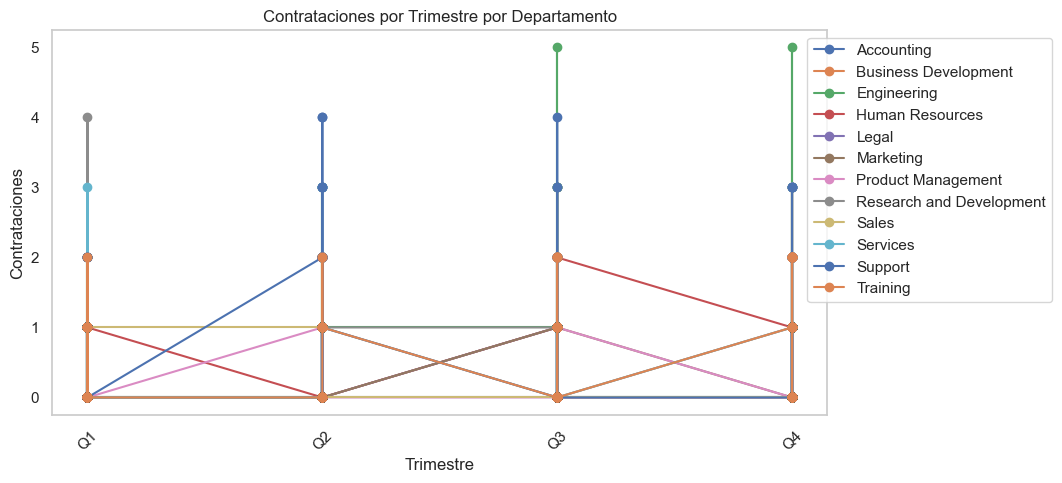

In [5]:
def json_to_df(json_data, columns=None):
    """Convierte JSON a DataFrame con las columnas indicadas."""
    return pd.DataFrame(json_data["rows"], columns=columns) if "rows" in json_data else None

# 1️⃣ Obtener y visualizar métricas trimestrales
quarterly_hiring = client.get_quarterly_hiring()
df_quarterly = json_to_df(quarterly_hiring, columns=["department", "job", "Q1", "Q2", "Q3", "Q4"])

if df_quarterly is not None:
    # Convertir de formato ancho a largo para graficar mejor
    df_long = df_quarterly.melt(id_vars=["department", "job"], 
                                var_name="quarter", 
                                value_name="hires")
    print(df_long)

    # 📊 Gráfico de contrataciones por trimestre
    plt.figure(figsize=(10, 5))
    for dept, dept_data in df_long.groupby("department"):
        plt.plot(dept_data["quarter"], dept_data["hires"], marker='o', label=dept)

    plt.xlabel("Trimestre")
    plt.ylabel("Contrataciones")
    plt.title("Contrataciones por Trimestre por Departamento")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
else:
    print("❌ Error obteniendo datos trimestrales")

                 department  total_hires
0      Business Development          187
1               Engineering          208
2           Human Resources          204
3                 Marketing          143
4  Research and Development          151
5                  Services          204
6                   Support          221


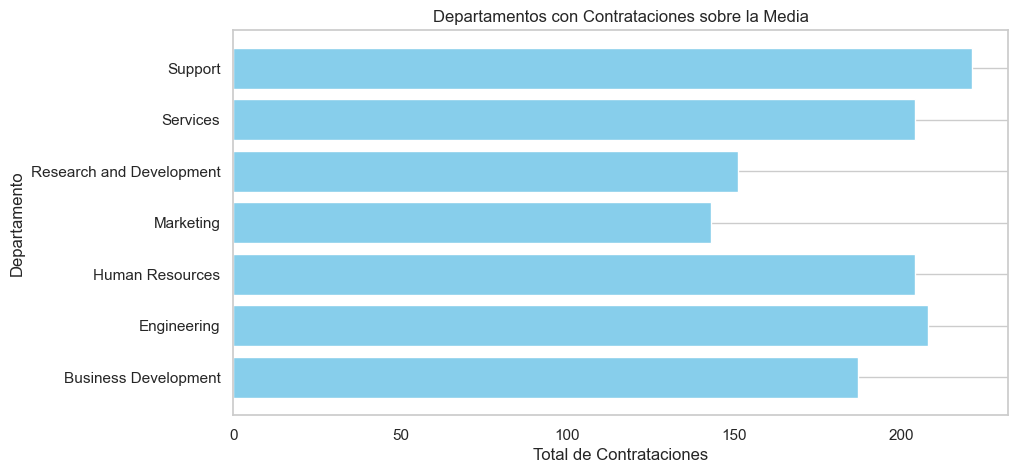

In [7]:
# 2️⃣ Obtener y visualizar departamentos sobre la media
departments_above_mean = client.get_departments_above_mean()
df_raw = json_to_df(departments_above_mean, columns=["id", "department", "hired"])

if df_raw is not None:
    # Agrupar por departamento y sumar contrataciones
    df_above_mean = df_raw.groupby("department", as_index=False)["hired"].sum()
    df_above_mean.rename(columns={"hired": "total_hires"}, inplace=True)

    print(df_above_mean)

    # 📊 Gráfico de departamentos sobre la media
    plt.figure(figsize=(10, 5))
    plt.barh(df_above_mean["department"], df_above_mean["total_hires"], color="skyblue")
    plt.xlabel("Total de Contrataciones")
    plt.ylabel("Departamento")
    plt.title("Departamentos con Contrataciones sobre la Media")
    plt.grid(axis='x')
    plt.show()
else:
    print("❌ Error obteniendo departamentos sobre la media")

In [6]:
print(departments_above_mean)

NameError: name 'departments_above_mean' is not defined